# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

In [ ]:
!pip install --default-timeout=100 tabgan

Defaulting to user installation because normal site-packages is not writeable
  Using cached tabgan-1.2.0-py2.py3-none-any.whl (45 kB)
     |████████████████████████████████| 2.0 MB 129 kB/s            
  Using cached pandas-1.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached torchvision-0.12.0-cp39-cp39-manylinux1_x86_64.whl (21.0 MB)
     |████████████████████████████████| 247 kB 2.2 MB/s            
  Using cached category_encoders-2.4.0-py2.py3-none-any.whl (86 kB)
  Using cached numpy-1.22.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
     |████████████████████████████████| 7.2 MB 79 kB/s             
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3.9 /tmp/pip-standalone-pip-44ulezpf/__env_pip__.zip/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-vvbqejjl/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i h

     |████████████████████████████████| 44 kB 165 kB/s            
     |████████████████████████████████| 44 kB 164 kB/s            
  Using cached scikit_learn-1.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.4 MB)
     |██████████████▎                 | 335.0 MB 4.8 MB/s eta 0:01:27 

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
import warnings
warnings.filterwarnings("ignore")

# Dataset Information

In [2]:
dataset_train=pd.read_csv('KDDTrain.csv')

In [3]:
dataset_test=pd.read_csv('KDDTest.csv')

# Sample view of the training dataset

In [4]:
dataset_train.head()

duration  protocol_type   service  flag   src_bytes   dst_bytes   land  \
0         0            tcp  ftp_data    SF         491           0      0   
1         0            udp     other    SF         146           0      0   
2         0            tcp   private    S0           0           0      0   
3         0            tcp      http    SF         232        8153      0   
4         0            tcp      http    SF         199         420      0   

    wrong_fragment   urgent   hot  ...   dst_host_srv_count  \
0                0        0     0  ...                   25   
1                0        0     0  ...                    1   
2                0        0     0  ...                   26   
3                0        0     0  ...                  255   
4                0        0     0  ...                  255   

    dst_host_same_srv_rate   dst_host_diff_srv_rate  \
0                     0.17                     0.03   
1                     0.00                     0.60   
2                     0.10                     0.05   
3                     1.00                     0.00   
4                     1.00                     0.00   

    dst_host_same_src_port_rate   dst_host_srv_diff_host_rate  \
0                          0.17                          0.00   
1                          0.88                          0.00   
2                          0.00                          0.00   
3                          0.03                          0.04   
4                          0.00                          0.00   

    dst_host_serror_rate    dst_host_srv_serror_rate   dst_host_rerror_rate  \
0                   0.00                        0.00                   0.05   
1                   0.00                        0.00                   0.00   
2                   1.00                        1.00                   0.00   
3                   0.03                        0.01                   0.00   
4                   0.00                        0.00                   0.00   

    dst_host_srv_rerror_rate   classification.  
0                       0.00            normal  
1                       0.00            normal  
2                       0.00               Dos  
3                       0.01            normal  
4                       0.00            normal  

[5 rows x 42 columns]

# Sample view of the test dataset

In [5]:
dataset_test.head()

0   tcp   private   REJ    0.1    0.2  0.3  0.4  0.5  0.6  ...  10.1  \
0  0   tcp   private   REJ      0      0    0    0    0    0  ...     1   
1  2   tcp  ftp_data    SF  12983      0    0    0    0    0  ...    86   
2  0  icmp     eco_i    SF     20      0    0    0    0    0  ...    57   
3  1   tcp    telnet  RSTO      0     15    0    0    0    0  ...    86   
4  0   tcp      http    SF    267  14515    0    0    0    0  ...   255   

   0.04.1  0.06.1  0.22  0.23  0.24  0.25   1.2   1.3  neptune  
0    0.00    0.06  0.00  0.00  0.00   0.0  1.00  1.00  neptune  
1    0.61    0.04  0.61  0.02  0.00   0.0  0.00  0.00   normal  
2    1.00    0.00  1.00  0.28  0.00   0.0  0.00  0.00    saint  
3    0.31    0.17  0.03  0.02  0.00   0.0  0.83  0.71    mscan  
4    1.00    0.00  0.01  0.03  0.01   0.0  0.00  0.00   normal  

[5 rows x 42 columns]

# Columns Name of Training and Test dataset

In [6]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


# Shape of Training and Test

In [1]:
print("Shape of Training Dataset:", dataset_train.shape)
print("Shape of Testing Dataset:", dataset_test.shape)

NameError: name 'dataset_train' is not defined

# Columns Assignement

In [8]:
# Assigning attribute name to dataset
dataset_train = pd.read_csv("KDDTrain.csv", header=None, names = col_names)
dataset_test = pd.read_csv("KDDTest.csv", header=None, names = col_names)

# Label of training and test dataset

In [9]:
#label distribution of Training set and testing set
print('Label distribution Training set:')
print(dataset_train['label'].value_counts())
print()
print('Label distribution Test set:')
print(dataset_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Data preprocessing

One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features. Requirement for One-Hot-encoding: "The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range [0, n_values)."

Therefore the features first need to be transformed with LabelEncoder, to transform every category to a number


# Identify categorical features¶

In [10]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in dataset_train.columns:
    if dataset_train[col_name].dtypes == 'object' :
        unique_cat = len(dataset_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(dataset_train['service'].value_counts().sort_values(ascending=False).head())


Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [11]:
# Test set
print('Test set:')
for col_name in dataset_test.columns:
    if dataset_test[col_name].dtypes == 'object' :
        unique_cat = len(dataset_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


### Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.
### Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

# LabelEncoder


### Insert categorical features into a 2D numpy array


In [12]:
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
dataset_train_categorical_values = dataset_train[categorical_columns]
dataset_test_categorical_values = dataset_test[categorical_columns]


In [13]:
dataset_train_categorical_values.head()

protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF

# Dummy Columns

In [14]:
# protocol type
unique_protocol=sorted(dataset_train.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(dataset_train.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(dataset_train.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(dataset_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

# Transform categorical features into numbers using LabelEncoder()

In [15]:
#Transform categorical features into numbers using LabelEncoder()
dataset_train_categorical_values_enc=dataset_train_categorical_values.apply(LabelEncoder().fit_transform)
print(dataset_train_categorical_values_enc.head())
# test set
dataset_test_categorical_values_enc=dataset_test_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


# One-Hot-Encoding

In [16]:
#One-Hot-Encoding¶
enc = OneHotEncoder()
dataset_train_categorical_values_encenc = enc.fit_transform(dataset_train_categorical_values_enc)
dataset_train_cat_data = pd.DataFrame(dataset_train_categorical_values_encenc.toarray(),columns=dumcols)
# test set
dataset_test_categorical_values_encenc = enc.fit_transform(dataset_test_categorical_values_enc)
dataset_test_cat_data = pd.DataFrame(dataset_test_categorical_values_encenc.toarray(),columns=testdumcols)



In [17]:
dataset_train_cat_data.head()

Protocol_type_icmp  Protocol_type_tcp  Protocol_type_udp  service_IRC  \
0                 0.0                1.0                0.0          0.0   
1                 0.0                0.0                1.0          0.0   
2                 0.0                1.0                0.0          0.0   
3                 0.0                1.0                0.0          0.0   
4                 0.0                1.0                0.0          0.0   

   service_X11  service_Z39_50  service_aol  service_auth  service_bgp  \
0          0.0             0.0          0.0           0.0          0.0   
1          0.0             0.0          0.0           0.0          0.0   
2          0.0             0.0          0.0           0.0          0.0   
3          0.0             0.0          0.0           0.0          0.0   
4          0.0             0.0          0.0           0.0          0.0   

   service_courier  ...  flag_REJ  flag_RSTO  flag_RSTOS0  flag_RSTR  flag_S0  \
0              0.0  ...       0.0        0.0          0.0        0.0      0.0   
1              0.0  ...       0.0        0.0          0.0        0.0      0.0   
2              0.0  ...       0.0        0.0          0.0        0.0      1.0   
3              0.0  ...       0.0        0.0          0.0        0.0      0.0   
4              0.0  ...       0.0        0.0          0.0        0.0      0.0   

   flag_S1  flag_S2  flag_S3  flag_SF  flag_SH  
0      0.0      0.0      0.0      1.0      0.0  
1      0.0      0.0      0.0      1.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      1.0      0.0  
4      0.0      0.0      0.0      1.0      0.0  

[5 rows x 84 columns]

# Add 6 missing categories from train set to test set

In [18]:
trainservice=dataset_train['service'].tolist()
testservice= dataset_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference


['service_http_2784',
 'service_urh_i',
 'service_red_i',
 'service_harvest',
 'service_http_8001',
 'service_aol']

In [19]:
for col in difference:
    dataset_test_cat_data[col] = 0

dataset_test_cat_data.shape

(22544, 84)

# Join encoded categorical dataframe with the non-categorical dataframe

In [20]:
#Join encoded categorical dataframe with the non-categorical dataframe
newdf=dataset_train.join(dataset_train_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=dataset_test.join(dataset_test_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


# Split Dataset into 4 datasets for every attack category
## Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
## Replace labels column with new labels column
## Make new datasets


In [21]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())


0    0
1    0
2    1
3    0
4    0
Name: label, dtype: object


In [22]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


#  Feature Scaling:¶


In [23]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

# Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [24]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

# Use StandardScaler() to scale the dataframes

In [25]:
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)


# Check that the Standard Deviation is 1

In [26]:
print(X_DoS.std(axis=0))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]


In [27]:
X_Probe.std(axis=0);
X_R2L.std(axis=0);
X_U2R.std(axis=0);

# Step 3: Feature Selection:

# 1. Univariate Feature Selection using ANOVA F-test

In [28]:
#univariate feature selection with ANOVA F-test. using secondPercentile method, then RFE
#Scikit-learn exposes feature selection routines as objects that implement the transform method
#SelectPercentile: removes all but a user-specified highest scoring percentage of features
#f_classif: ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape


(113270, 13)

# Get the features that were selected: DoS

In [29]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [30]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

(78999, 13)

# Get the features that were selected: Probe

In [31]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [32]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

(68338, 13)

### Get the features that were selected: R2L

In [33]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [34]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

(67395, 13)

# Get the features that were selected: U2R


In [35]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

# Summary of features selected by Univariate Feature Selection

In [36]:
print('Features selected for DoS:',newcolname_DoS)
print()
print('Features selected for Probe:',newcolname_Probe)
print()
print('Features selected for R2L:',newcolname_R2L)
print()
print('Features selected for U2R:',newcolname_U2R)

Features selected for DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Features selected for Probe: ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Features selected for R2L: ['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Features selected for U2R: ['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_

# The authors state that "After obtaining the adequate number of features during the univariate selection process, a recursive feature elimination (RFE) was operated with the number of features passed as parameter to identify the features selected". This either implies that RFE is only used for obtaining the features previously selected but also obtaining the rank. This use of RFE is however very redundant as the features selected can be obtained in another way (Done in this project). One can also not say that the features were selected by RFE, as it was not used for this. The quote could however also imply that only the number 13 from univariate feature selection was used. RFE is then used for feature selection trying to find the best 13 features. With this use of RFE one can actually say that it was used for feature selection. However the authors obtained different numbers of features for every attack category, 12 for DoS, 15 for Probe, 13 for R2L and 11 for U2R. This concludes that it is not clear what mechanism is used for feature selection.


# To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.
#2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)¶

In [37]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = DecisionTreeClassifier(random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))



DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'count'), (3, 'flag_SF'), (4, 'dst_host_serror_rate'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_count'), (8, 'logged_in'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [38]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_srv_count'), (3, 'dst_host_rerror_rate'), (4, 'service_private'), (5, 'logged_in'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'flag_SF'), (9, 'service_eco_i'), (10, 'rerror_rate'), (11, 'Protocol_type_icmp'), (12, 'dst_host_srv_rerror_rate'), (13, 'srv_rerror_rate')]


In [39]:

rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'dst_bytes'), (3, 'hot'), (4, 'dst_host_srv_diff_host_rate'), (5, 'service_ftp_data'), (6, 'dst_host_same_src_port_rate'), (7, 'dst_host_srv_count'), (8, 'num_failed_logins'), (9, 'service_imap4'), (10, 'is_guest_login'), (11, 'service_ftp'), (12, 'flag_RSTO'), (13, 'service_http')]


In [40]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'hot'), (2, 'dst_host_srv_count'), (3, 'dst_host_count'), (4, 'root_shell'), (5, 'num_shells'), (6, 'service_ftp_data'), (7, 'dst_host_srv_diff_host_rate'), (8, 'num_file_creations'), (9, 'dst_host_same_src_port_rate'), (10, 'service_telnet'), (11, 'srv_diff_host_rate'), (12, 'service_http'), (13, 'urgent')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)¶

In [41]:
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS.astype(int))
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)


In [42]:
rfe.fit(X_Probe, Y_Probe.astype(int))
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [43]:
rfe.fit(X_R2L, Y_R2L.astype(int))
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [44]:
rfe.fit(X_U2R, Y_U2R.astype(int))
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of features selected by RFE


In [45]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)


Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_count', 'dst_host_count', 'dst_host_same_sr

In [46]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


# Step 4: Build the model:


# Classifier is trained for all features and for reduced features, for later comparison.


# The classifier model itself is stored in the clf variable.

In [47]:
# all features
clf_DoS=DecisionTreeClassifier(random_state=0)
clf_Probe=DecisionTreeClassifier(random_state=0)
clf_R2L=DecisionTreeClassifier(random_state=0)
clf_U2R=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_U2R.fit(X_U2R, Y_U2R.astype(int))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [48]:
# selected features
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
clf_rfeProbe=DecisionTreeClassifier(random_state=0)
clf_rfeR2L=DecisionTreeClassifier(random_state=0)
clf_rfeU2R=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS.astype(int))
clf_rfeProbe.fit(X_rfeProbe, Y_Probe.astype(int))
clf_rfeR2L.fit(X_rfeR2L, Y_R2L.astype(int))
clf_rfeU2R.fit(X_rfeU2R, Y_U2R.astype(int))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

# 5. Prediction & Evaluation (validation):


# Using all Features for each category

# Confusion Matrices : DoS


In [49]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

array([1, 1, 0, ..., 0, 0, 0])

In [50]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [51]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     1
Actual attacks               
0                  9499   212
1                  2830  4630

# Confusion Matrices : Probe

In [52]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     2
Actual attacks               
0                  2337  7374
2                   212  2209

# Confusion Matrices : R2L

In [53]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0    3
Actual attacks              
0                  9707    4
3                  2573  312

# Confusion Matrices : U2R

In [54]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0  4
Actual attacks            
0                  9703  8
4                    60  7

# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS¶


In [55]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99639 (+/- 0.00341)
Precision: 0.99505 (+/- 0.00477)
Recall: 0.99665 (+/- 0.00483)
F-measure: 0.99585 (+/- 0.00392)


# Probe¶


In [56]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99571 (+/- 0.00328)
Precision: 0.99391 (+/- 0.00684)
Recall: 0.99267 (+/- 0.00405)
F-measure: 0.99329 (+/- 0.00512)


# R2L¶


In [57]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97920 (+/- 0.01054)
Precision: 0.97150 (+/- 0.01741)
Recall: 0.96957 (+/- 0.01381)
F-measure: 0.97050 (+/- 0.01482)


# U2R¶


In [58]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.99663 (+/- 0.00259)
Precision: 0.86481 (+/- 0.08952)
Recall: 0.91672 (+/- 0.10661)
F-measure: 0.88628 (+/- 0.07462)


# RFECV for illustration¶


In [59]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

Automatically created module for IPython interactive environment


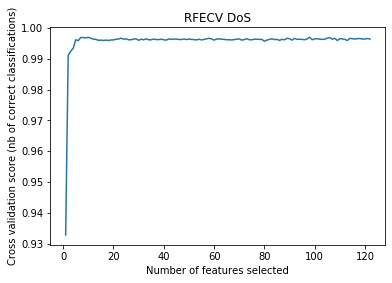

In [60]:
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

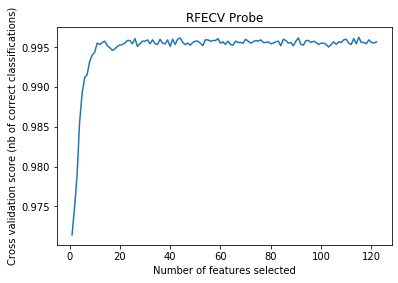

In [61]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

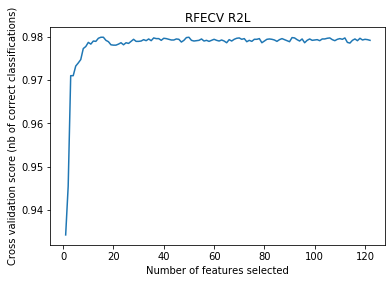

In [62]:
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

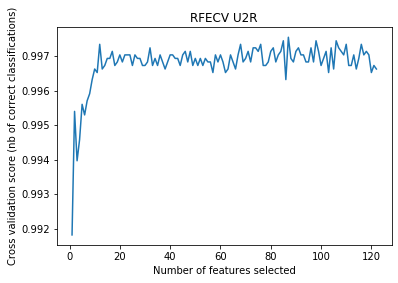

In [63]:
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

# Random Forest Model

In [64]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE
clf1 = RandomForestClassifier(n_jobs=2, random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf1, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))



DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'dst_host_srv_serror_rate'), (3, 'flag_SF'), (4, 'count'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_serror_rate'), (8, 'logged_in'), (9, 'dst_host_count'), (10, 'srv_serror_rate'), (11, 'service_http'), (12, 'serror_rate'), (13, 'flag_S0')]


In [65]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_diff_srv_rate'), (3, 'service_private'), (4, 'service_eco_i'), (5, 'dst_host_srv_count'), (6, 'dst_host_srv_diff_host_rate'), (7, 'dst_host_rerror_rate'), (8, 'dst_host_srv_rerror_rate'), (9, 'logged_in'), (10, 'rerror_rate'), (11, 'srv_rerror_rate'), (12, 'Protocol_type_icmp'), (13, 'flag_SF')]


In [66]:
rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'hot'), (3, 'dst_host_same_src_port_rate'), (4, 'service_ftp_data'), (5, 'dst_host_srv_diff_host_rate'), (6, 'dst_host_srv_count'), (7, 'service_ftp'), (8, 'dst_bytes'), (9, 'service_http'), (10, 'num_failed_logins'), (11, 'is_guest_login'), (12, 'flag_RSTO'), (13, 'service_imap4')]


In [67]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'num_file_creations'), (2, 'dst_host_count'), (3, 'dst_host_srv_count'), (4, 'hot'), (5, 'root_shell'), (6, 'dst_host_srv_diff_host_rate'), (7, 'dst_host_same_src_port_rate'), (8, 'service_ftp_data'), (9, 'num_shells'), (10, 'service_telnet'), (11, 'urgent'), (12, 'service_http'), (13, 'srv_diff_host_rate')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)¶

In [68]:
from sklearn.feature_selection import RFE
clf1 = RandomForestClassifier(n_jobs=2, random_state=0)
rfe = RFE(estimator=clf1, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS.astype(int))
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)


In [69]:
rfe.fit(X_Probe, Y_Probe.astype(int))
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [70]:
rfe.fit(X_R2L, Y_R2L.astype(int))
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [71]:
rfe.fit(X_U2R, Y_U2R.astype(int))
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of Features selected by RFE

In [72]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)


Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'count', 'srv_count', 'same_srv_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'Protocol_type_icmp', 'Protocol_type_tcp', 'flag_SF']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_tcp', 'service_eco_i', 'service_private']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'service_ftp', 'service_ftp_data']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'dst_host_count', 'ds

In [73]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


# Build RF model

# Classifier is trained for all features and for reduced features, for later comparison.

# The classifier model itself is stored in the clf variable.

In [74]:
# all features
clf1_DoS=RandomForestClassifier(random_state=0)
clf1_Probe=RandomForestClassifier(random_state=0)
clf1_R2L=RandomForestClassifier(random_state=0)
clf1_U2R=RandomForestClassifier(random_state=0)
clf1_DoS.fit(X_DoS, Y_DoS.astype(int))
clf1_Probe.fit(X_Probe, Y_Probe.astype(int))
clf1_R2L.fit(X_R2L, Y_R2L.astype(int))
clf1_U2R.fit(X_U2R, Y_U2R.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [75]:
# selected features
clf1_rfeDoS=RandomForestClassifier(random_state=0)
clf1_rfeProbe=RandomForestClassifier(random_state=0)
clf1_rfeR2L=RandomForestClassifier(random_state=0)
clf1_rfeU2R=RandomForestClassifier(random_state=0)
clf1_rfeDoS.fit(X_rfeDoS, Y_DoS.astype(int))
clf1_rfeProbe.fit(X_rfeProbe, Y_Probe.astype(int))
clf1_rfeR2L.fit(X_rfeR2L, Y_R2L.astype(int))
clf1_rfeU2R.fit(X_rfeU2R, Y_U2R.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Evaluation and Predictions

# Confusion Matrices : DoS


In [76]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf1_DoS.predict(X_DoS_test)

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
# View the predicted probabilities of the first 10 observations
clf1_DoS.predict_proba(X_DoS_test)[0:10]

array([[0.6, 0.4],
       [0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.5, 0.5],
       [0.8, 0.2]])

In [78]:
Y_DoS_pred=clf1_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0    1
Actual attacks              
0                  9188  523
1                  6901  559

# Confusion Matrices : Probe


In [79]:
Y_Probe_pred=clf1_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     2
Actual attacks               
0                  9522   189
2                  1256  1165

# Confusion Matrices : R2L

In [80]:
Y_R2L_pred=clf1_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0  3
Actual attacks            
0                  9711  0
3                  2884  1

# Confusion Matrices : U2R

In [81]:
Y_U2R_pred=clf1_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0
Actual attacks         
0                  9711
4                    67

# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS¶

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99819 (+/- 0.00211)
Precision: 0.99919 (+/- 0.00132)
Recall: 0.99665 (+/- 0.00468)
F-measure: 0.99792 (+/- 0.00244)


# Probe

In [83]:
accuracy = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99613 (+/- 0.00295)
Precision: 0.99618 (+/- 0.00466)
Recall: 0.99169 (+/- 0.00595)
F-measure: 0.99391 (+/- 0.00465)


# R2L

In [84]:
accuracy = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.98039 (+/- 0.00775)
Precision: 0.97501 (+/- 0.00958)
Recall: 0.96926 (+/- 0.01519)
F-measure: 0.97205 (+/- 0.01121)


# U2R

In [85]:
accuracy = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf1_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.99703 (+/- 0.00250)
Precision: 0.94882 (+/- 0.12792)
Recall: 0.82826 (+/- 0.15928)
F-measure: 0.87118 (+/- 0.11935)


# RFECV for illustration¶

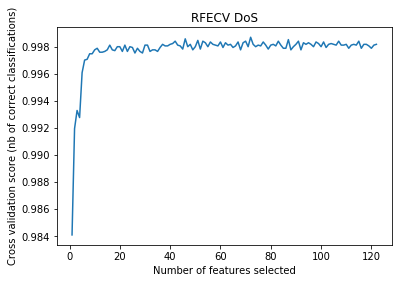

In [86]:
rfecv_DoS = RFECV(estimator=clf1_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

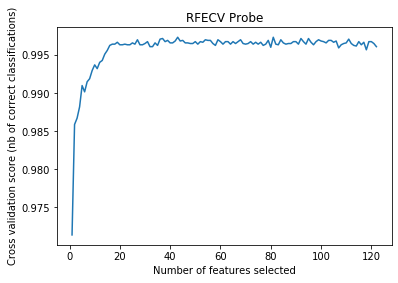

In [87]:
rfecv_Probe = RFECV(estimator=clf1_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

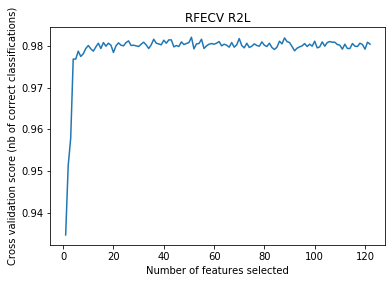

In [88]:
rfecv_R2L = RFECV(estimator=clf1_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

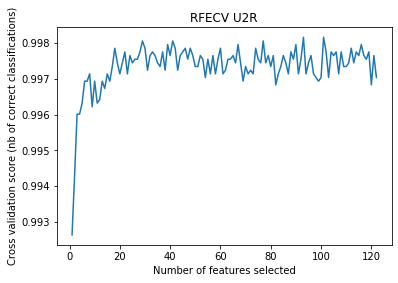

In [89]:
rfecv_U2R = RFECV(estimator=clf1_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

# To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.
#2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)¶

# Naive Bayes Model

In [90]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
clf2 =GaussianNB()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf2, n_features_to_select=13)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'count'), (1, 'dst_host_count'), (1, 'dst_host_same_srv_rate'), (1, 'dst_host_serror_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_serror_rate'), (1, 'flag_S0'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'same_srv_rate'), (1, 'serror_rate'), (1, 'service_http'), (1, 'srv_serror_rate')]


In [91]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'Protocol_type_icmp'), (1, 'dst_host_diff_srv_rate'), (1, 'dst_host_rerror_rate'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'dst_host_srv_rerror_rate'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'rerror_rate'), (1, 'service_eco_i'), (1, 'service_private'), (1, 'srv_rerror_rate')]


In [92]:
rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'dst_bytes'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'flag_RSTO'), (1, 'hot'), (1, 'is_guest_login'), (1, 'num_failed_logins'), (1, 'service_ftp'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_imap4'), (1, 'src_bytes')]


In [93]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'dst_host_count'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'hot'), (1, 'num_file_creations'), (1, 'num_shells'), (1, 'root_shell'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_telnet'), (1, 'srv_diff_host_rate'), (1, 'urgent')]


# Building the Naive Bayes Model

In [94]:
# all features
clf2_DoS=GaussianNB()
clf2_Probe=GaussianNB()
clf2_R2L=GaussianNB()
clf2_U2R=GaussianNB()
clf2_DoS.fit(X_DoS, Y_DoS.astype(int))
clf2_Probe.fit(X_Probe, Y_Probe.astype(int))
clf2_R2L.fit(X_R2L, Y_R2L.astype(int))
clf2_U2R.fit(X_U2R, Y_U2R.astype(int))

GaussianNB(priors=None, var_smoothing=1e-09)

# Evaluation and Predictions

# Confusion Matrices : DoS

In [95]:
clf2_DoS.predict(X_DoS_test)

array([0, 0, 0, ..., 0, 0, 0])

In [96]:
# View the predicted probabilities of the first 10 observations
clf2_DoS.predict_proba(X_DoS_test)[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [97]:
Y_DoS_pred=clf2_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     1
Actual attacks               
0                  9447   264
1                  3701  3759

# Confusion Matrices : Probe

In [98]:
Y_Probe_pred=clf2_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks    0     2
Actual attacks              
0                   76  9635
2                  201  2220

# Confusion Matrices : R2L

In [99]:
Y_R2L_pred=clf2_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0
Actual attacks         
0                  9711
3                  2885

# Confusion Matrices : U2R

In [100]:
Y_U2R_pred=clf2_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0
Actual attacks         
0                  9711
4                    67

# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.86733 (+/- 0.01474)
Precision: 0.98822 (+/- 0.01158)
Recall: 0.70308 (+/- 0.03682)
F-measure: 0.82145 (+/- 0.02371)


# Probe

In [102]:
accuracy = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97898 (+/- 0.01148)
Precision: 0.97323 (+/- 0.00912)
Recall: 0.96051 (+/- 0.03039)
F-measure: 0.96654 (+/- 0.01926)


# R2L

In [103]:
accuracy = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.93561 (+/- 0.01004)
Precision: 0.89097 (+/- 0.01370)
Recall: 0.95508 (+/- 0.00770)
F-measure: 0.91620 (+/- 0.01202)


# U2R

In [104]:
accuracy = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf2_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))


Accuracy: 0.97259 (+/- 0.01121)
Precision: 0.60132 (+/- 0.02891)
Recall: 0.97911 (+/- 0.04265)
F-measure: 0.66067 (+/- 0.04235)


# KNeighbour Classifier

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
clf3 = KNeighborsClassifier()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf3, n_features_to_select=13)
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'count'), (1, 'dst_host_count'), (1, 'dst_host_same_srv_rate'), (1, 'dst_host_serror_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_serror_rate'), (1, 'flag_S0'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'same_srv_rate'), (1, 'serror_rate'), (1, 'service_http'), (1, 'srv_serror_rate')]


In [106]:
rfe.fit(X_newProbe, Y_Probe.astype(int))
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'Protocol_type_icmp'), (1, 'dst_host_diff_srv_rate'), (1, 'dst_host_rerror_rate'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'dst_host_srv_rerror_rate'), (1, 'flag_SF'), (1, 'logged_in'), (1, 'rerror_rate'), (1, 'service_eco_i'), (1, 'service_private'), (1, 'srv_rerror_rate')]


In [107]:
rfe.fit(X_newR2L, Y_R2L.astype(int))
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'dst_bytes'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'flag_RSTO'), (1, 'hot'), (1, 'is_guest_login'), (1, 'num_failed_logins'), (1, 'service_ftp'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_imap4'), (1, 'src_bytes')]


In [108]:
rfe.fit(X_newU2R, Y_U2R.astype(int))
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'dst_host_count'), (1, 'dst_host_same_src_port_rate'), (1, 'dst_host_srv_count'), (1, 'dst_host_srv_diff_host_rate'), (1, 'hot'), (1, 'num_file_creations'), (1, 'num_shells'), (1, 'root_shell'), (1, 'service_ftp_data'), (1, 'service_http'), (1, 'service_telnet'), (1, 'srv_diff_host_rate'), (1, 'urgent')]


# Building the KNearistNeighbour Classifier

In [ ]:
# all features
clf3_DoS=KNeighborsClassifier()
clf3_Probe=KNeighborsClassifier()
clf3_R2L=KNeighborsClassifier()
clf3_U2R=KNeighborsClassifier()
clf3_DoS.fit(X_DoS, Y_DoS.astype(int))
clf3_Probe.fit(X_Probe, Y_Probe.astype(int))
clf3_R2L.fit(X_R2L, Y_R2L.astype(int))
clf3_U2R.fit(X_U2R, Y_U2R.astype(int))

# Evaluation and Predictions

In [ ]:
# Confusion Matrices : DoS

In [ ]:
clf3_DoS.predict(X_DoS_test)

In [ ]:
# View the predicted probabilities of the first 10 observations
clf3_DoS.predict_proba(X_DoS_test)[0:10]

In [ ]:
Y_DoS_pred=clf3_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Confusion Matrices : Probe

In [ ]:
Y_Probe_pred=clf3_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Confusion Matrices : R2L

In [ ]:
Y_R2L_pred=clf3_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Confusion Matrices : U2R

In [ ]:
Y_U2R_pred=clf3_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

# Cross Validation: Accuracy, Precision, Recall, F-measure¶


# DoS

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

# Probe

In [ ]:
accuracy = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

# R2L

In [ ]:
accuracy = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

# U2R

In [ ]:
accuracy = cross_val_score(clf3_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf3_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf3_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf3_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
